In [1]:
from PIL import Image
import scipy as sp
import torch
import numpy as np
import skimage.graph
from skimage.util import map_array
from sklearn.cluster import SpectralClustering, KMeans
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sp_linalg


In [2]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_array = np.array(image)
    return image_array / 255

def construct_adjacency_matrix(image_array):
    height, width, _ = image_array.shape
    nodes = []
    row_indices = []
    col_indices = []
    data = []

    for i in range(height):
        for j in range(width):
            node_index = i * width + j
            nodes.append(node_index)

            for di, dj in ((-1, 0), (1, 0), (0, -1), (0, 1)):
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width:
                    neighbor_index = ni * width + nj
                    row_indices.append(node_index)
                    col_indices.append(neighbor_index)
                    diff = image_array[i, j] - image_array[ni, nj]
                    distance = np.linalg.norm(diff) ** 2
                    data.append(np.exp(-distance / 0.1 ** 2))

    adjacency_matrix = sp.sparse.coo_matrix((data, (row_indices, col_indices)), shape=(len(nodes), len(nodes)))

    return adjacency_matrix

def normalize_adjacency_matrix(adjacency_matrix):
    degrees_sqrt_inv = 1.0 / np.sqrt(adjacency_matrix.sum(axis=1))
    normalized_adj = adjacency_matrix.multiply(degrees_sqrt_inv)
    normalized_adj = normalized_adj.multiply(degrees_sqrt_inv.T)
    return normalized_adj

def sparse_to_torch_coo(sparse_matrix):
    torch_adj = torch.sparse_coo_tensor(
        torch.LongTensor([sparse_matrix.row, sparse_matrix.col]),
        torch.FloatTensor(sparse_matrix.data),
        torch.Size(sparse_matrix.shape)
    )
    return torch_adj.coalesce()

# Main program
image_path = '/content/scene2.jpg'

# Image preprocessing
image_array = preprocess_image(image_path)

# Construct sparse adjacency matrix
adjacency_matrix = construct_adjacency_matrix(image_array)

# Normalize adjacency matrix
normalized_adjacency_matrix = normalize_adjacency_matrix(adjacency_matrix)

# Convert to PyTorch COO format
torch_adjacency_matrix = sparse_to_torch_coo(normalized_adjacency_matrix)


<ipython-input-2-b6bfdbb355c6>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  torch.LongTensor([sparse_matrix.row, sparse_matrix.col]),


-------------a--------------


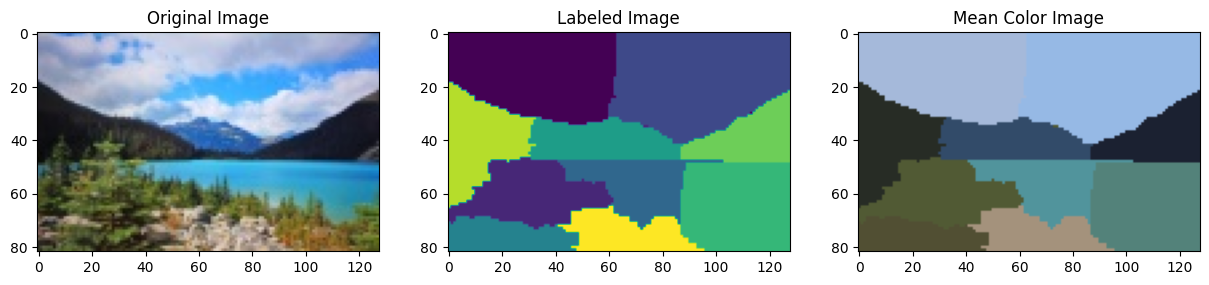

-------------b--------------


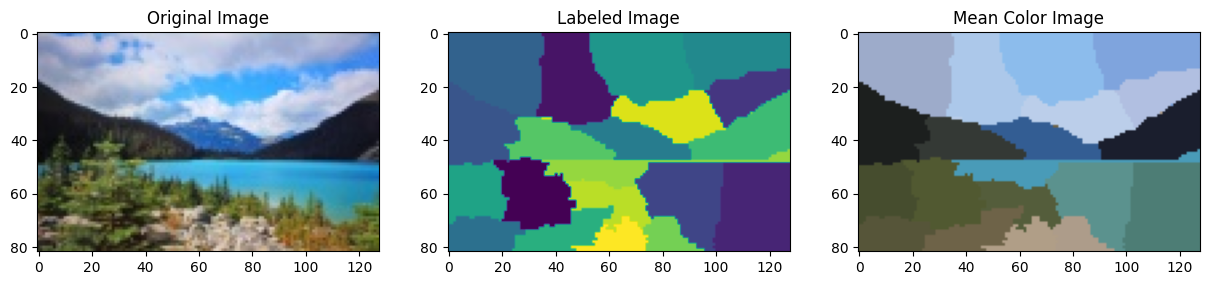

In [4]:

def clustered_mean_image_generator(image_path, torch_adjacency_matrix, n_clusters):

    image = Image.open(image_path).convert('RGB')
    image_array = np.array(image) / 255

    _, normalized_eigenvectors = torch.lobpcg(torch_adjacency_matrix, k=n_clusters, largest=True)
    normalized_eigenvectors = normalized_eigenvectors / torch.norm(normalized_eigenvectors, dim=0, keepdim=True)
    normalized_eigenvectors = normalized_eigenvectors / torch.norm(normalized_eigenvectors, dim=1, keepdim=True)

    numpy_eigenvectors = normalized_eigenvectors.detach().cpu().numpy()

    km = KMeans(n_clusters=n_clusters, n_init=10, init='k-means++', random_state=42)
    labels = km.fit_predict(numpy_eigenvectors)

    labeled_image = labels.reshape(image_array.shape[0], image_array.shape[1])

    mean_color_image = np.zeros_like(image_array)
    for cluster_label in range(n_clusters):
        indices = np.where(labeled_image == cluster_label)
        if indices[0].size > 0:
            mean_color = np.mean(image_array[indices], axis=0)
            mean_color_image[indices] = mean_color

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image_array)

    plt.subplot(1, 3, 2)
    plt.title('Labeled Image')
    plt.imshow(labeled_image)

    plt.subplot(1, 3, 3)
    plt.title('Mean Color Image')
    plt.imshow(mean_color_image)

    plt.show()


image_path = '/content/scene2.jpg'
print("-------------a--------------")
clustered_mean_image_generator(image_path, torch_adjacency_matrix, n_clusters=10)
print("-------------b--------------")
clustered_mean_image_generator(image_path, torch_adjacency_matrix, n_clusters=20)
